# TinyML sur Arduino
## Tutoriel de reconnaissance de gestes
## Compatible Windows



**Objectif :** Créer un modèle de reconnaissance de gestes qui peut fonctionner sur un microcontrôleur Arduino.

**Ce que vous allez apprendre :**
- Comment préparer des données d'accéléromètre et de gyroscope
- Comment entraîner un réseau de neurones pour classifier des gestes
- Comment convertir le modèle pour l'utiliser sur Arduino
- Les concepts fondamentaux du machine learning (réseaux de neurones, loss, optimisation)

**Matériel nécessaire :**
- Arduino Nano 33 BLE Sense (avec accéléromètre et gyroscope intégrés)
- Fichiers CSV contenant les données d'entraînement (`punch.csv` et `flex.csv`)

In [2]:
# Vérifier la version de Python
import sys
print(f"Version Python: {sys.version}")
print(f"Version Python (majeur.mineur): {sys.version_info.major}.{sys.version_info.minor}")

# TensorFlow nécessite Python 3.8-3.11
# Si vous avez Python 3.12+, essayez les solutions ci-dessous
if sys.version_info >= (3, 12):
    print("\n⚠️ ATTENTION: Python 3.12+ détecté. TensorFlow standard ne supporte que Python 3.8-3.11.")
    print("Solutions possibles:")
    print("1. Utiliser une version de développement de TensorFlow (peut être instable)")
    print("2. Créer un environnement virtuel avec Python 3.11")
    print("\nTentative d'installation avec tensorflow-cpu...")
    print("Si cela échoue, créez un environnement virtuel avec Python 3.11")
else:
    print("\n✓ Version Python compatible avec TensorFlow")

Version Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Version Python (majeur.mineur): 3.10

✓ Version Python compatible avec TensorFlow


## Configuration de l'environnement Python

### 📚 Bibliothèques nécessaires

Ce tutoriel utilise plusieurs bibliothèques Python essentielles :

- **NumPy** : Manipulation de tableaux numériques et calculs mathématiques
- **Pandas** : Lecture et manipulation des fichiers CSV
- **Matplotlib** : Visualisation des données (graphiques)
- **TensorFlow** : Framework de machine learning pour créer et entraîner le réseau de neurones

### ⚠️ IMPORTANT - Compatibilité Python

- **TensorFlow nécessite Python 3.8 à 3.11**
- Si vous avez Python 3.12 ou supérieur, vous devez soit:
  1. Créer un environnement virtuel avec Python 3.11 (recommandé)
  2. Utiliser une version de développement de TensorFlow (peut être instable)

### Installation sur Windows (PowerShell)

```powershell
# Option 1: Créer un environnement virtuel avec Python 3.11 (recommandé)
python3.11 -m venv venv
.\venv\Scripts\Activate.ps1
pip install numpy pandas matplotlib tensorflow

# Option 2: Si vous avez Python 3.12+, essayer tensorflow-cpu
pip install numpy pandas matplotlib tensorflow-cpu
```

In [3]:
# Installation des dépendances (essayer différentes approches selon la version Python)
import sys
import subprocess

def install_package(package_name):
    """Installe un package avec pip"""
    try:
        result = subprocess.run([sys.executable, "-m", "pip", "install", package_name], 
                              capture_output=True, text=True)
        return result.returncode == 0
    except Exception as e:
        return False

# Vérifier si TensorFlow est déjà installé
try:
    import tensorflow as tf
    print(f"✓ TensorFlow déjà installé: {tf.__version__}")
    print("✓ Toutes les dépendances sont prêtes!")
except ImportError:
    print("Installation des dépendances...")
    
    # Installer numpy, pandas, matplotlib (généralement compatibles)
    packages = ["numpy", "pandas", "matplotlib"]
    for pkg in packages:
        if install_package(pkg):
            print(f"✓ {pkg} installé")
        else:
            print(f"⚠️ Échec installation de {pkg}")
    
    # Installer TensorFlow selon la version Python
    if sys.version_info >= (3, 12):
        print("\n⚠️ Python 3.12+ détecté. TensorFlow standard ne supporte que Python 3.8-3.11.")
        print("Tentative avec tensorflow-cpu...")
        
        if install_package("tensorflow-cpu"):
            print("✓ tensorflow-cpu installé avec succès")
        else:
            print("\n❌ ÉCHEC: tensorflow-cpu ne peut pas être installé avec Python 3.12+")
            print("\n📋 SOLUTION: Créez un environnement virtuel avec Python 3.11:")
            print("   1. py -3.11 -m venv venv")
            print("   2. .\\venv\\Scripts\\Activate.ps1")
            print("   3. pip install numpy pandas matplotlib tensorflow")
            print("   4. Sélectionnez le kernel Python 3.11 dans votre notebook")
    else:
        # Pour Python 3.8-3.11, installation standard
        if install_package("tensorflow"):
            print("✓ TensorFlow installé avec succès")
        else:
            print("⚠️ Échec installation de TensorFlow. Essayez manuellement: pip install tensorflow")


✓ TensorFlow déjà installé: 2.18.0
✓ Toutes les dépendances sont prêtes!


## Solution recommandée: Environnement virtuel avec Python 3.11

Si vous avez Python 3.12 ou supérieur, la meilleure solution est de créer un environnement virtuel avec Python 3.11.

**Étapes à suivre:**

1. **Télécharger Python 3.11** (si pas déjà installé):
   - Allez sur https://www.python.org/downloads/
   - Téléchargez Python 3.11.x
   - Installez-le (cochez "Add Python to PATH")

2. **Créer l'environnement virtuel** (dans PowerShell, dans le dossier du projet):
   ```powershell
   py -3.11 -m venv venv
   .\venv\Scripts\Activate.ps1
   pip install --upgrade pip
   pip install numpy pandas matplotlib tensorflow
   ```

3. **Dans Jupyter, sélectionner le kernel Python 3.11:**
   - Si vous utilisez VS Code: sélectionnez l'interpréteur Python 3.11 de l'environnement virtuel
   - Si vous utilisez Jupyter Notebook: installez le kernel:
     ```powershell
     .\venv\Scripts\Activate.ps1
     pip install ipykernel
     python -m ipykernel install --user --name=tinyml-env --display-name "Python 3.11 (TinyML)"
     ```
   - Puis sélectionnez le kernel "Python 3.11 (TinyML)" dans le notebook


In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)
print("TensorFlow:", tf.__version__)


NumPy: 1.26.4
Pandas: 2.1.2
Matplotlib: 3.8.0
TensorFlow: 2.18.0


In [5]:
# Vérifier la version de Python
import sys
print(f"Version Python: {sys.version}")
print(f"Version Python (majeur.mineur): {sys.version_info.major}.{sys.version_info.minor}")

# TensorFlow nécessite Python 3.8-3.11
# Si vous avez Python 3.12+, essayez les solutions ci-dessous
if sys.version_info >= (3, 12):
    print("\n⚠️ ATTENTION: Python 3.12+ détecté. TensorFlow standard ne supporte que Python 3.8-3.11.")
    print("Solutions possibles:")
    print("1. Utiliser une version de développement de TensorFlow (peut être instable)")
    print("2. Créer un environnement virtuel avec Python 3.11")
    print("\nTentative d'installation avec tensorflow-cpu...")
    print("Si cela échoue, créez un environnement virtuel avec Python 3.11")
else:
    print("\n✓ Version Python compatible avec TensorFlow")

Version Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Version Python (majeur.mineur): 3.10

✓ Version Python compatible avec TensorFlow


## Gestes utilisés : Flex et Punch

Dans les projets TinyML basés sur accéléromètre et gyroscope, **Flex** et **Punch** sont deux gestes de référence servant à entraîner et tester un modèle de reconnaissance de mouvements.

---

### Geste : Punch

**Description**  
Mouvement rapide et impulsif du bras vers l’avant, similaire à un coup de poing.

**Caractéristiques physiques**
- Accélération forte et soudaine
- Mouvement court
- Direction dominante (souvent axe X ou Y)
- Peu de rotation

**Signature capteurs**
- Pic net sur l’accéléromètre
- Signal bref
- Gyroscope peu sollicité

**Intérêt en machine learning**
- Facile à détecter
- Très discriminant
- Idéal pour introduire la classification de gestes dynamiques



---

### Geste : Flex

**Description**  
Flexion contrôlée du bras, comme contracter le biceps.

**Caractéristiques physiques**
- Mouvement lent et progressif
- Accélération modérée
- Forte rotation du bras
- Durée plus longue

**Signature capteurs**
- Variation douce de l’accéléromètre
- Signal étalé dans le temps
- Gyroscope fortement sollicité

**Intérêt en machine learning**
- Geste plus subtil
- Permet d’apprendre des patterns temporels
- Utile pour différencier gestes lents vs rapides

> *(Insérer ici une photo illustrant le geste Flex)*

---

### Comparaison rapide

| Geste  | Type de mouvement | Durée | Accélération | Rotation |
|------|------------------|-------|--------------|----------|
| Punch | Explosif         | Courte| Forte        | Faible   |
| Flex  | Contrôlé         | Longue| Modérée      | Forte    |

Ces deux gestes sont volontairement opposés afin de faciliter l’apprentissage et l’évaluation d’un modèle TinyML embarqué.


### Les gestes à reconnaître

Voici les deux gestes que le modèle va apprendre à classifier :

<div style="display: flex; justify-content: space-around; align-items: center; margin: 20px 0; flex-wrap: wrap;">
  <div style="text-align: center; margin: 10px;">
    <img src="punch.png" alt="Geste Punch" width="300" style="border: 2px solid #ddd; border-radius: 8px; padding: 10px; max-width: 100%;">
    <p style="margin-top: 10px;"><strong>Punch</strong><br>Coup de poing</p>
  </div>
  <div style="text-align: center; margin: 10px;">
    <img src="flex.png" alt="Geste Flex" width="300" style="border: 2px solid #ddd; border-radius: 8px; padding: 10px; max-width: 100%;">
    <p style="margin-top: 10px;"><strong>Flex</strong><br>Flexion</p>
  </div>
</div>


## 📁 Charger les données

### Préparation des fichiers

Avant de commencer, assurez-vous que les fichiers de données sont disponibles :

- `punch.csv` : Données d'accéléromètre/gyroscope pour le geste "coup de poing"
- `flex.csv` : Données d'accéléromètre/gyroscope pour le geste "flexion"

**Sur Windows :** Copiez simplement ces fichiers dans le même dossier que ce notebook.

### Format des données

Chaque fichier CSV contient des colonnes :
- `aX`, `aY`, `aZ` : Accélération sur les axes X, Y, Z (en G)
- `gX`, `gY`, `gZ` : Vitesse angulaire (gyroscope) sur les axes X, Y, Z (en deg/s)

Ces données ont été enregistrées depuis un Arduino Nano 33 BLE Sense pendant que vous effectuiez les gestes.

## 📊 Visualisation des données (optionnel)

### Pourquoi visualiser ?

Avant d'entraîner le modèle, il est utile de visualiser les données pour :
- **Vérifier la qualité** : S'assurer que les données sont cohérentes
- **Comprendre les patterns** : Voir comment les gestes diffèrent visuellement
- **Détecter les anomalies** : Identifier d'éventuelles erreurs d'enregistrement

### Deux graphiques séparés

Nous créons deux graphiques distincts pour l'accélération et le gyroscope car :
- **Unités différentes** : Accélération en G, gyroscope en deg/s
- **Échelles différentes** : Les valeurs n'ont pas la même amplitude
- **Facilite l'analyse** : Permet de mieux comprendre chaque type de mesure

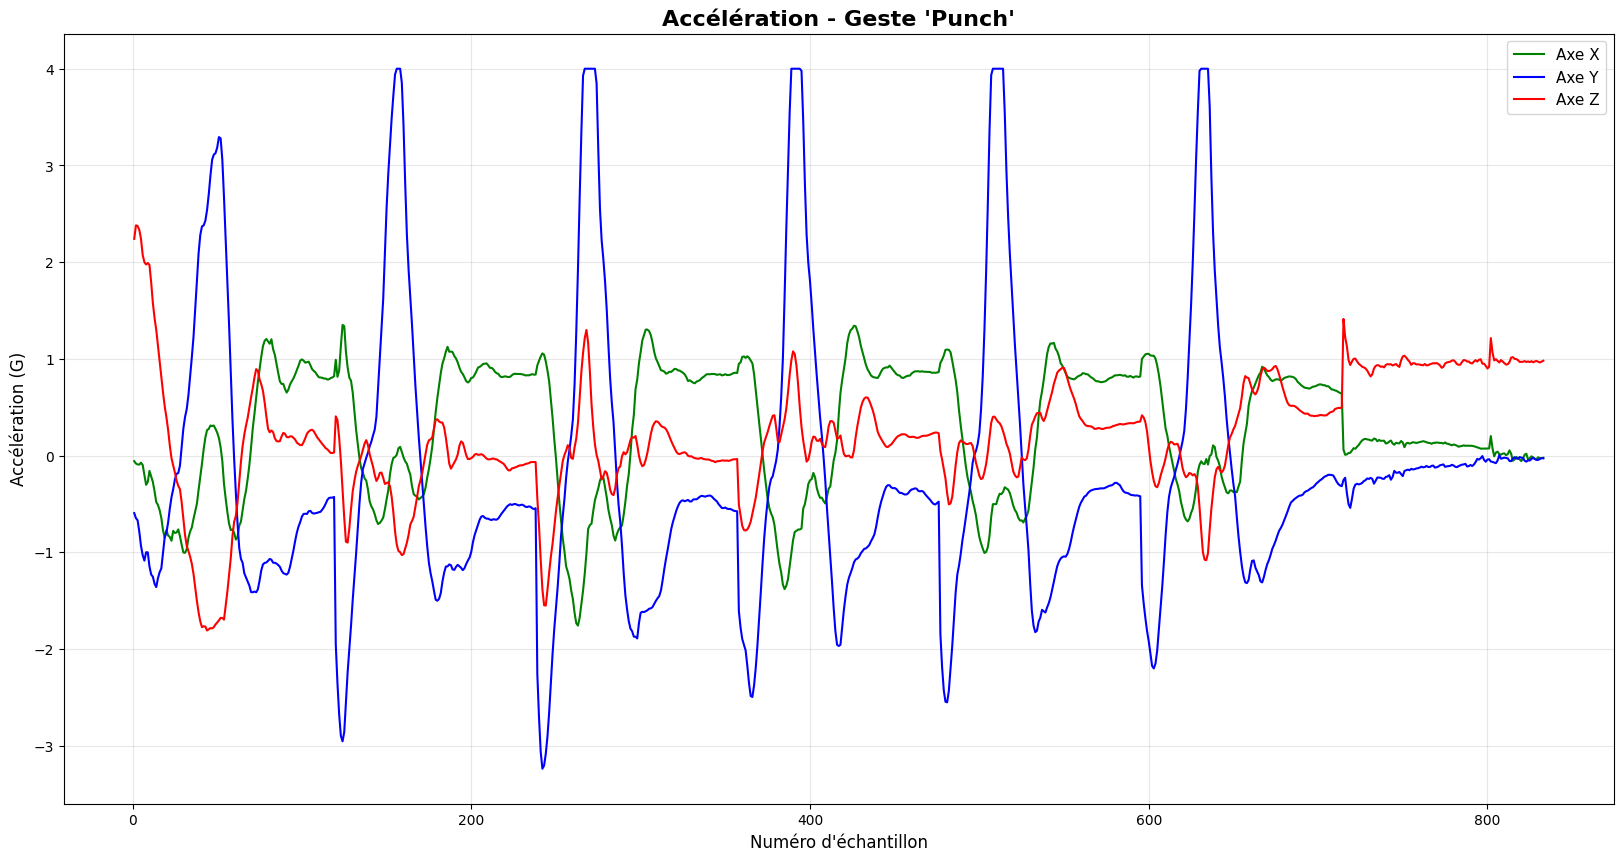

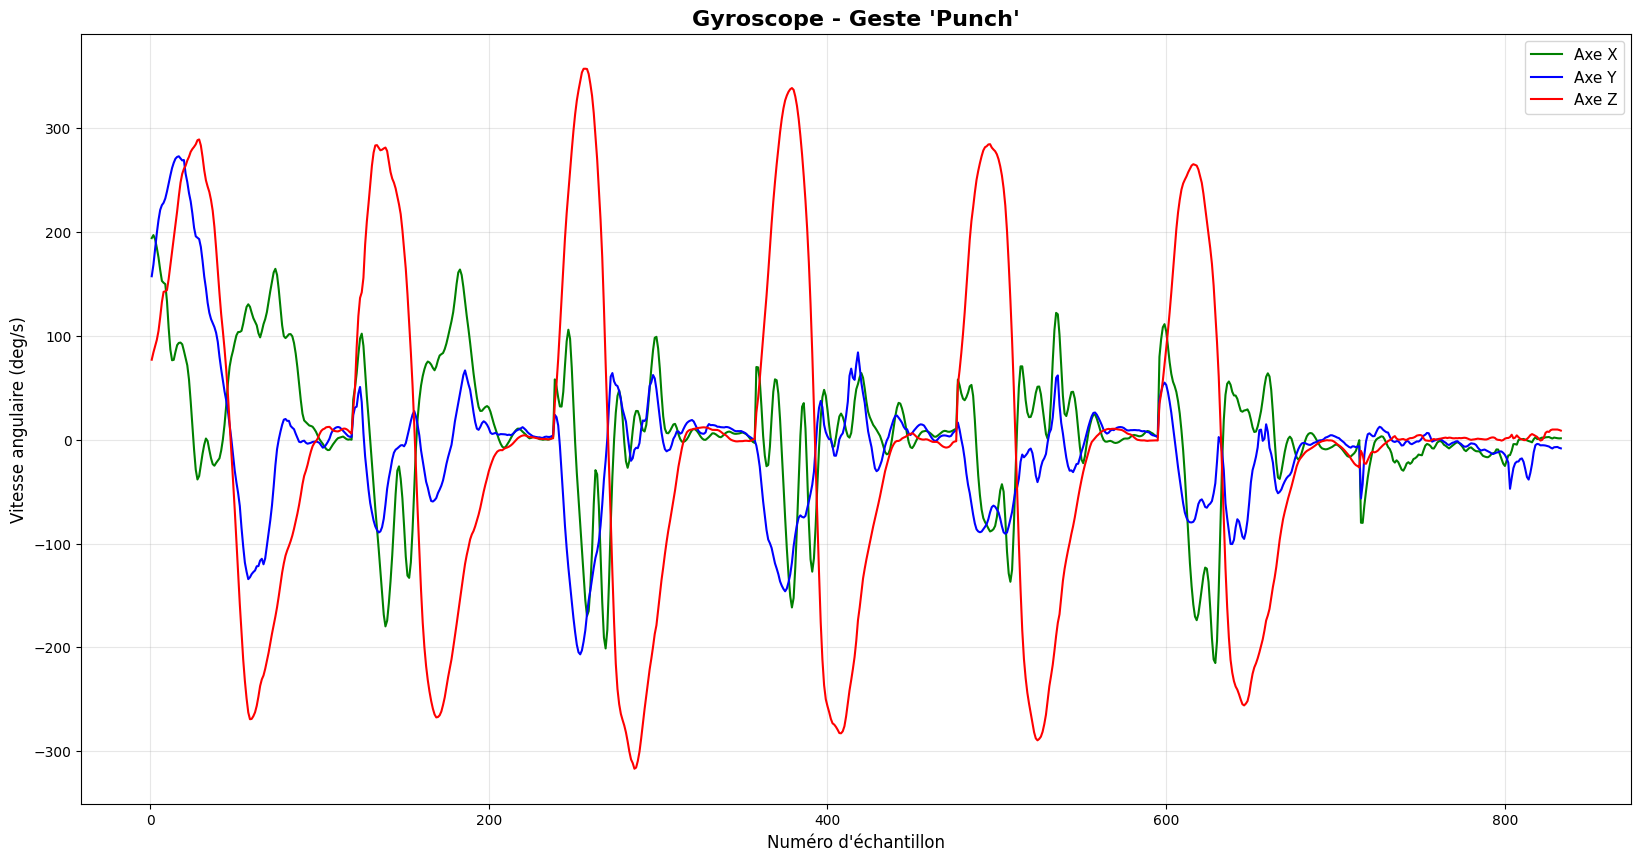

✓ Visualisation terminée. Vous pouvez voir les patterns du geste 'punch'.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Charger les données du geste "punch" (coup de poing)
filename = "punch.csv"

# Utiliser le chemin relatif pour compatibilité Windows
df = pd.read_csv(filename)

# Créer un index pour l'axe X (numéro d'échantillon)
index = range(1, len(df['aX']) + 1)

# Définir la taille des graphiques (largeur, hauteur en pouces)
plt.rcParams["figure.figsize"] = (20, 10)

# Graphique 1 : Accélération
# Les couleurs : vert (g) pour X, bleu (b) pour Y, rouge (r) pour Z
plt.plot(index, df['aX'], 'g-', label='Axe X', linewidth=1.5)
plt.plot(index, df['aY'], 'b-', label='Axe Y', linewidth=1.5)
plt.plot(index, df['aZ'], 'r-', label='Axe Z', linewidth=1.5)
plt.title("Accélération - Geste 'Punch'", fontsize=16, fontweight='bold')
plt.xlabel("Numéro d'échantillon", fontsize=12)
plt.ylabel("Accélération (G)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# Graphique 2 : Gyroscope
plt.plot(index, df['gX'], 'g-', label='Axe X', linewidth=1.5)
plt.plot(index, df['gY'], 'b-', label='Axe Y', linewidth=1.5)
plt.plot(index, df['gZ'], 'r-', label='Axe Z', linewidth=1.5)
plt.title("Gyroscope - Geste 'Punch'", fontsize=16, fontweight='bold')
plt.xlabel("Numéro d'échantillon", fontsize=12)
plt.ylabel("Vitesse angulaire (deg/s)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("✓ Visualisation terminée. Vous pouvez voir les patterns du geste 'punch'.")


## 🧠 Entraîner le réseau de neurones

Dans cette section, nous allons :
1. **Préparer les données** : Formater les CSV pour l'entraînement
2. **Diviser les données** : Créer des ensembles d'entraînement, validation et test
3. **Construire le modèle** : Créer l'architecture du réseau de neurones
4. **Entraîner** : Apprendre au modèle à reconnaître les gestes
5. **Évaluer** : Vérifier la performance du modèle


## 📋 Analyser et préparer les données

### Objectif de cette étape

Transformer les fichiers CSV bruts en un format utilisable par le réseau de neurones.

### Concepts clés

1. **Normalisation** : Convertir les valeurs brutes (accélération, gyroscope) en valeurs entre 0 et 1
   - Pourquoi ? Les réseaux de neurones apprennent mieux avec des données normalisées
   - Accélération : de -4G à +4G → normalisée entre 0 et 1
   - Gyroscope : de -2000 à +2000 deg/s → normalisée entre 0 et 1

2. **One-hot encoding** : Représenter chaque geste par un vecteur binaire
   - "punch" → [1, 0]
   - "flex" → [0, 1]
   - Pourquoi ? Format standard pour la classification multi-classes

3. **Format d'entrée** : Chaque geste = 119 échantillons × 6 valeurs (aX, aY, aZ, gX, gY, gZ) = 714 valeurs

### Configuration

Si vous avez enregistré d'autres gestes, ajoutez-les à la liste `GESTURES` ci-dessous.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"Version TensorFlow = {tf.__version__}\n")

# ============================================
# REPRODUCTIBILITÉ
# ============================================
# Définir une graine aléatoire fixe pour obtenir les mêmes résultats
# à chaque exécution. Important pour la reproductibilité des expériences.
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ============================================
# CONFIGURATION DES GESTES
# ============================================
# Liste des gestes à reconnaître (doit correspondre aux noms des fichiers CSV)
GESTURES = [
    "punch",  # Coup de poing
    "flex"    # Flexion
]

# Nombre d'échantillons par geste (119 échantillons = ~2 secondes à 50Hz)
SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# ============================================
# ONE-HOT ENCODING
# ============================================
# Créer une matrice d'encodage one-hot pour les sorties
# punch → [1, 0]
# flex   → [0, 1]
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)
print("Encodage one-hot:")
for i, gesture in enumerate(GESTURES):
    print(f"  {gesture}: {ONE_HOT_ENCODED_GESTURES[i]}")

# ============================================
# PRÉPARATION DES DONNÉES
# ============================================
inputs = []  # Liste des entrées (données normalisées)
outputs = []  # Liste des sorties (labels one-hot)

# Parcourir chaque fichier CSV de geste
for gesture_index in range(NUM_GESTURES):
    gesture = GESTURES[gesture_index]
    print(f"\n📁 Traitement de l'index {gesture_index} pour le geste '{gesture}'...")

    # Récupérer le vecteur one-hot correspondant à ce geste
    output = ONE_HOT_ENCODED_GESTURES[gesture_index]

    # Lire le fichier CSV
    df = pd.read_csv(gesture + ".csv")

    # Supprimer les lignes vides qui causeraient des erreurs (NaN)
    df = df.dropna()
    df = df.reset_index(drop=True)

    # Calculer le nombre d'enregistrements de ce geste dans le fichier
    # Chaque enregistrement = SAMPLES_PER_GESTURE échantillons
    num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
    print(f"   ✓ {num_recordings} enregistrement(s) du geste '{gesture}' trouvé(s)")

    # Pour chaque enregistrement du geste
    for i in range(num_recordings):
        tensor = []  # Vecteur d'entrée pour cet enregistrement
        
        # Pour chaque échantillon dans cet enregistrement
        for j in range(SAMPLES_PER_GESTURE):
            index = i * SAMPLES_PER_GESTURE + j
            
            # ============================================
            # NORMALISATION DES DONNÉES
            # ============================================
            # Convertir les valeurs brutes en valeurs entre 0 et 1
            # Formule: (valeur - min) / (max - min)
            # 
            # Accélération: de -4G à +4G → normalisée entre 0 et 1
            #   (valeur + 4) / 8
            # 
            # Gyroscope: de -2000 à +2000 deg/s → normalisée entre 0 et 1
            #   (valeur + 2000) / 4000
            
            tensor += [
                (df['aX'][index] + 4) / 8,      # Accélération X normalisée
                (df['aY'][index] + 4) / 8,      # Accélération Y normalisée
                (df['aZ'][index] + 4) / 8,      # Accélération Z normalisée
                (df['gX'][index] + 2000) / 4000,  # Gyroscope X normalisé
                (df['gY'][index] + 2000) / 4000,  # Gyroscope Y normalisé
                (df['gZ'][index] + 2000) / 4000   # Gyroscope Z normalisé
            ]

        # Ajouter cet enregistrement aux listes
        inputs.append(tensor)   # 714 valeurs (119 échantillons × 6 valeurs)
        outputs.append(output)   # Vecteur one-hot [1,0] ou [0,1]

# Convertir les listes en tableaux NumPy (format requis par TensorFlow)
inputs = np.array(inputs)
outputs = np.array(outputs)

print(f"\n✅ Préparation des données terminée !")
print(f"   - Nombre total d'enregistrements: {len(inputs)}")
print(f"   - Taille de chaque entrée: {inputs.shape[1]} valeurs")
print(f"   - Nombre de gestes: {NUM_GESTURES}")

Version TensorFlow = 2.18.0

Encodage one-hot:
  punch: [1. 0.]
  flex: [0. 1.]

📁 Traitement de l'index 0 pour le geste 'punch'...
   ✓ 7 enregistrement(s) du geste 'punch' trouvé(s)

📁 Traitement de l'index 1 pour le geste 'flex'...
   ✓ 7 enregistrement(s) du geste 'flex' trouvé(s)

✅ Préparation des données terminée !
   - Nombre total d'enregistrements: 14
   - Taille de chaque entrée: 714 valeurs
   - Nombre de gestes: 2


## 🔀 Mélanger et diviser les données

### Pourquoi diviser les données ?

En machine learning, on divise toujours les données en **trois ensembles** :

1. **Ensemble d'entraînement (60%)** : 
   - Utilisé pour **apprendre** au modèle à reconnaître les gestes
   - Le modèle ajuste ses paramètres (poids) sur ces données

2. **Ensemble de validation (20%)** :
   - Utilisé pendant l'entraînement pour **évaluer** les performances
   - Permet de détecter le surapprentissage (overfitting)
   - Aide à choisir les meilleurs hyperparamètres

3. **Ensemble de test (20%)** :
   - Utilisé **après** l'entraînement pour tester les performances finales
   - Données jamais vues par le modèle pendant l'apprentissage
   - Donne une estimation réaliste de la performance en conditions réelles

### Pourquoi mélanger ?

Mélanger les données avant de diviser garantit que chaque ensemble contient une **représentation équilibrée** de tous les gestes, évitant les biais.

In [8]:
# ============================================
# MÉLANGER LES DONNÉES
# ============================================
# Créer un ordre aléatoire pour mélanger les données
# Cela garantit une distribution équilibrée dans chaque ensemble
num_inputs = len(inputs)
randomize = np.arange(num_inputs)  # [0, 1, 2, ..., num_inputs-1]
np.random.shuffle(randomize)        # Mélanger: [5, 12, 3, 0, ...]

# Réorganiser les données selon l'ordre aléatoire
inputs = inputs[randomize]
outputs = outputs[randomize]

# ============================================
# DIVISER EN TROIS ENSEMBLES
# ============================================
# Calculer les indices de division
# 60% pour l'entraînement, 20% pour la validation, 20% pour le test
TRAIN_SPLIT = int(0.6 * num_inputs)      # 60% des données
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)  # 60% + 20% = 80%

# Diviser les données
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("✅ Mélange et division des données terminés !")
print(f"\n📊 Répartition des données :")
print(f"   - Entraînement : {len(inputs_train)} échantillons ({len(inputs_train)/num_inputs*100:.1f}%)")
print(f"   - Validation   : {len(inputs_validate)} échantillons ({len(inputs_validate)/num_inputs*100:.1f}%)")
print(f"   - Test         : {len(inputs_test)} échantillons ({len(inputs_test)/num_inputs*100:.1f}%)")

✅ Mélange et division des données terminés !

📊 Répartition des données :
   - Entraînement : 8 échantillons (57.1%)
   - Validation   : 4 échantillons (28.6%)
   - Test         : 2 échantillons (14.3%)


## 🏗️ Construire et entraîner le modèle

### Qu'est-ce qu'un réseau de neurones ?

Un **réseau de neurones** est un modèle mathématique inspiré du cerveau humain. Il est composé de :

- **Couches (layers)** : Empilement de "neurones" qui transforment les données
- **Neurones** : Unités de calcul qui appliquent une fonction mathématique
- **Poids (weights)** : Paramètres que le modèle apprend pendant l'entraînement
- **Biais (biases)** : Valeurs ajustables pour chaque neurone

### Architecture de notre modèle

Nous utilisons un **réseau de neurones à propagation avant (feedforward)** avec :
- **Couche d'entrée** : 714 valeurs (119 échantillons × 6 mesures)
- **Couche cachée 1** : 50 neurones avec activation ReLU
- **Couche cachée 2** : 15 neurones avec activation ReLU  
- **Couche de sortie** : 2 neurones (un par geste) avec activation softmax

### Concepts importants

**ReLU (Rectified Linear Unit)** : Fonction d'activation qui garde les valeurs positives et met à zéro les négatives
- Formule : `f(x) = max(0, x)`
- Avantage : Rapide à calculer et évite certains problèmes d'apprentissage

**Softmax** : Fonction d'activation pour la dernière couche qui convertit les valeurs en probabilités
- Les sorties sont entre 0 et 1
- La somme des sorties = 1
- Permet d'interpréter les résultats comme des probabilités

Nous utilisons l'API [Keras](https://www.tensorflow.org/guide/keras) de TensorFlow pour construire le modèle.

In [9]:
# ============================================
# CONSTRUCTION DU MODÈLE
# ============================================
# Créer un modèle séquentiel (couches empilées les unes après les autres)
model = tf.keras.Sequential()

# Couche 1 : 50 neurones avec activation ReLU
# - ReLU est rapide et performante pour les réseaux de neurones
# - 50 neurones = capacité d'apprentissage intermédiaire
model.add(tf.keras.layers.Dense(50, activation='relu', name='couche_cachee_1'))

# Couche 2 : 15 neurones avec activation ReLU
# - Réduction progressive vers la sortie
# - Aide le modèle à apprendre des représentations plus abstraites
model.add(tf.keras.layers.Dense(15, activation='relu', name='couche_cachee_2'))

# Couche de sortie : NUM_GESTURES neurones (2 dans notre cas) avec activation softmax
# - Softmax convertit les valeurs en probabilités (somme = 1)
# - Chaque neurone représente la probabilité d'un geste
# - Exemple de sortie : [0.95, 0.05] = 95% punch, 5% flex
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax', name='couche_sortie'))

# ============================================
# COMPILATION DU MODÈLE
# ============================================
# Configurer comment le modèle va apprendre

# Optimiseur : RMSprop
# - Algorithme qui ajuste les poids pendant l'apprentissage
# - RMSprop adapte le taux d'apprentissage pour chaque paramètre
# - Bon compromis vitesse/stabilité

# Fonction de perte (Loss) : MSE (Mean Squared Error)
# - Mesure l'erreur entre les prédictions et les vraies valeurs
# - Formule : moyenne((prédiction - vraie_valeur)²)
# - Plus la loss est faible, meilleur est le modèle

# Métrique : MAE (Mean Absolute Error)
# - Erreur absolue moyenne
# - Plus facile à interpréter que MSE (même unité que les données)
model.compile(
    optimizer='rmsprop',      # Algorithme d'optimisation
    loss='mse',                # Fonction de perte (Mean Squared Error)
    metrics=['mae']            # Métrique à suivre (Mean Absolute Error)
)

# Afficher un résumé de l'architecture
print("📐 Architecture du modèle :")
model.summary()

print("\n🚀 Démarrage de l'entraînement...")
print("   - Epochs : 600 (nombre de passages sur toutes les données)")
print("   - Batch size : 1 (traitement d'un échantillon à la fois)")
print("   - Cela peut prendre quelques minutes...\n")

# ============================================
# ENTRAÎNEMENT DU MODÈLE
# ============================================
# epochs : nombre de fois que le modèle voit toutes les données d'entraînement
# batch_size : nombre d'échantillons traités avant de mettre à jour les poids
# validation_data : données pour évaluer les performances pendant l'entraînement
history = model.fit(
    inputs_train,              # Données d'entraînement
    outputs_train,            # Labels d'entraînement
    epochs=600,               # Nombre d'itérations
    batch_size=1,             # Taille du lot (1 = mise à jour après chaque échantillon)
    validation_data=(inputs_validate, outputs_validate),  # Données de validation
    verbose=1                  # Afficher la progression
)

print("\n✅ Entraînement terminé !")



📐 Architecture du modèle :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ couche_cachee_1 (Dense)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ couche_cachee_2 (Dense)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ couche_sortie (Dense)           │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


🚀 Démarrage de l'entraînement...
   - Epochs : 600 (nombre de passages sur toutes les données)
   - Batch size : 1 (traitement d'un échantillon à la fois)
   - Cela peut prendre quelques minutes...

Epoch 1/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1916 - mae: 0.2876 - val_loss: 0.9521 - val_mae: 0.9758
Epoch 2/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1456 - mae: 0.1814 - val_loss: 0.9525 - val_mae: 0.9759
Epoch 3/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1458 - mae: 0.1816 - val_loss: 0.9555 - val_mae: 0.9775
Epoch 4/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1458 - mae: 0.1800 - val_loss: 0.9556 - val_mae: 0.9776
Epoch 5/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1460 - mae: 0.1802 - val_loss: 0.9583 - val_mae: 0.9789
Epoch 6/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1457 - mae: 0.1784 - val_loss: 0.9553 - val_mae: 0.9774
Epoch 7/600
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1461 - mae: 0.1805 - val_loss: 0.9586 - val_m

## ✅ Vérifier les performances du modèle

### Pourquoi visualiser les performances ?

Après l'entraînement, il est crucial d'analyser les graphiques pour :

1. **Vérifier la convergence** : Le modèle apprend-il correctement ?
2. **Détecter le surapprentissage** : Le modèle mémorise-t-il les données au lieu d'apprendre ?
3. **Choisir le meilleur modèle** : À quel epoch le modèle est-il le plus performant ?

### Métriques à analyser

- **Loss (perte)** : Doit diminuer au fil des epochs
- **MAE (Mean Absolute Error)** : Erreur moyenne, doit aussi diminuer
- **Écart train/validation** : Si la validation stagne ou augmente, c'est du surapprentissage


### 📉 Graphique de la perte (Loss)

La **fonction de perte (loss)** mesure l'erreur du modèle :
- **Loss d'entraînement** : Erreur sur les données d'apprentissage
- **Loss de validation** : Erreur sur les données jamais vues pendant l'apprentissage

**Ce qu'on cherche :**
- Les deux courbes doivent **diminuer** ensemble
- Si la validation stagne ou augmente → **surapprentissage** (overfitting)
- Si les deux continuent à diminuer → le modèle peut encore apprendre

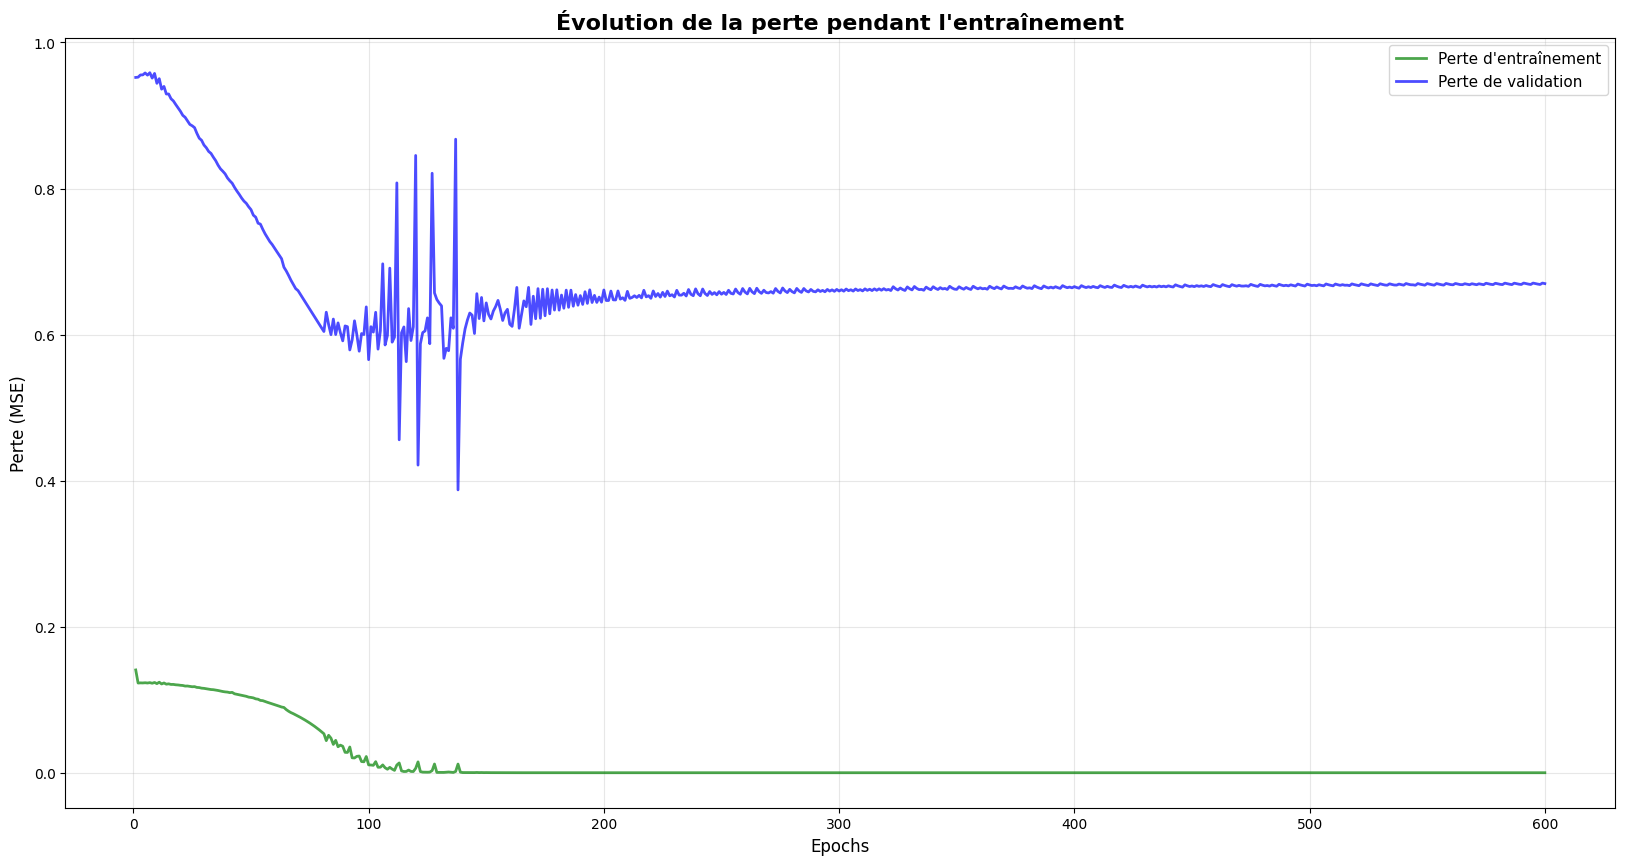

📊 Graphique généré avec 600 epochs
   - Perte finale d'entraînement : 0.0000
   - Perte finale de validation : 0.6698


In [10]:
# Définir la taille des graphiques (largeur, hauteur en pouces)
plt.rcParams["figure.figsize"] = (20, 10)

# Extraire les valeurs de perte de l'historique d'entraînement
loss = history.history['loss']           # Perte sur les données d'entraînement
val_loss = history.history['val_loss']  # Perte sur les données de validation
epochs = range(1, len(loss) + 1)        # Numéros des epochs (1, 2, 3, ...)

# Créer le graphique
plt.plot(epochs, loss, 'g-', label='Perte d\'entraînement', linewidth=2, alpha=0.7)
plt.plot(epochs, val_loss, 'b-', label='Perte de validation', linewidth=2, alpha=0.7)
plt.title('Évolution de la perte pendant l\'entraînement', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Perte (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"📊 Graphique généré avec {len(loss)} epochs")
print(f"   - Perte finale d'entraînement : {loss[-1]:.4f}")
print(f"   - Perte finale de validation : {val_loss[-1]:.4f}")

### 🔍 Graphique de la perte (zoom sur la convergence)

Les premiers epochs montrent souvent une **chute rapide** de la perte. En zoomant sur les epochs suivants, on peut mieux voir si le modèle **converge** (se stabilise) ou continue à s'améliorer.

**Convergence** : Quand la perte ne diminue plus significativement, le modèle a fini d'apprendre.

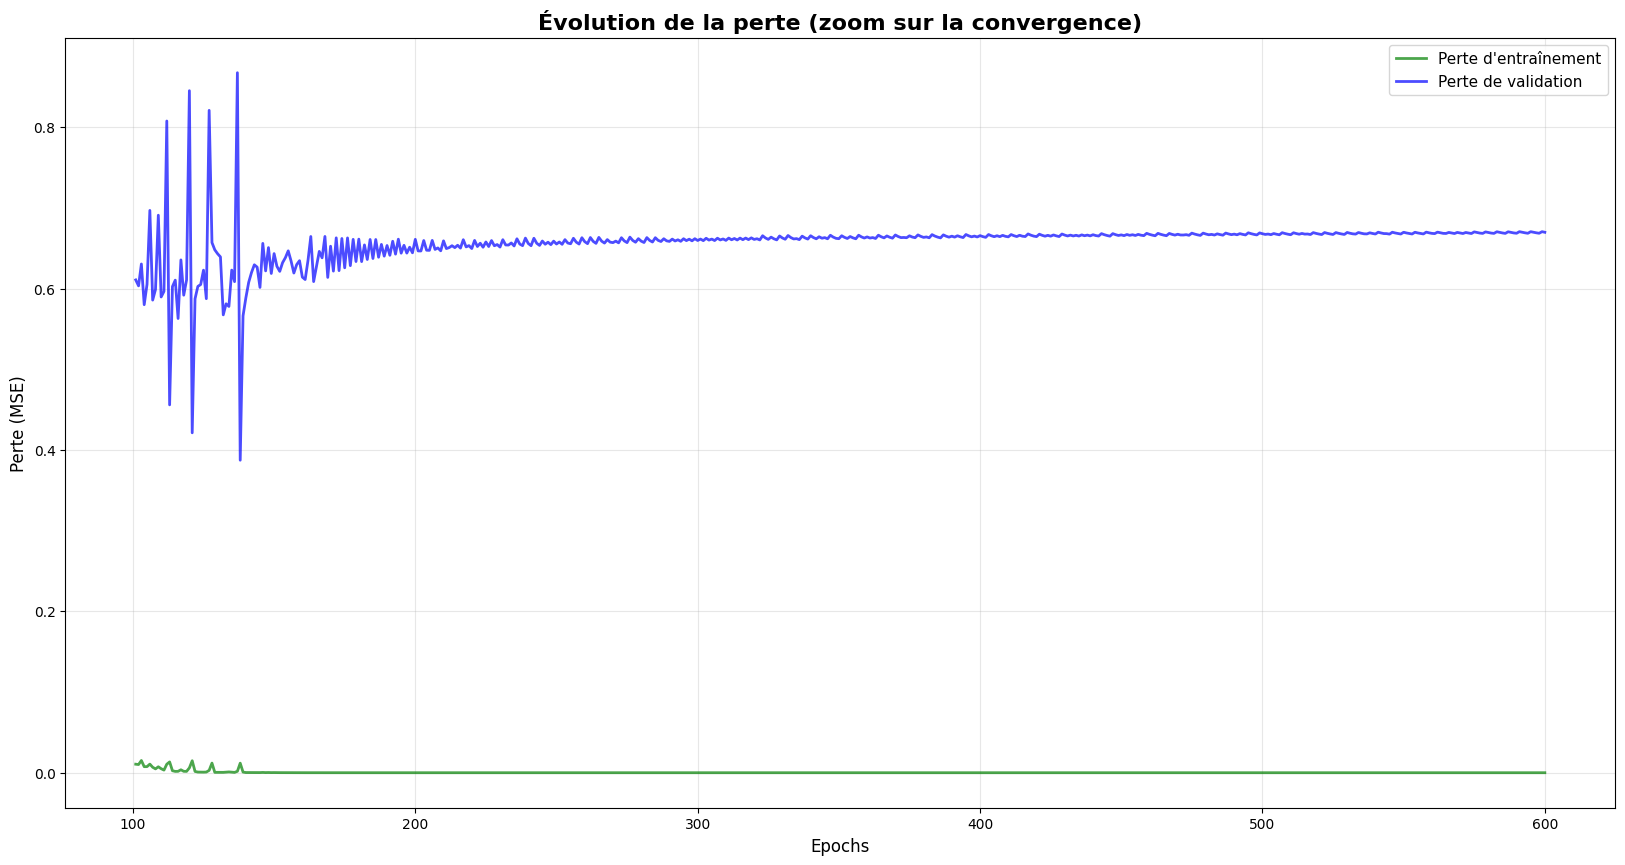

🔍 Vue zoomée à partir de l'epoch 101


In [11]:
# Graphique de la perte en sautant les premiers epochs
# Cela permet de mieux voir la convergence (stabilisation) du modèle
SKIP = 100  # Ignorer les 100 premiers epochs

plt.plot(epochs[SKIP:], loss[SKIP:], 'g-', label='Perte d\'entraînement', linewidth=2, alpha=0.7)
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b-', label='Perte de validation', linewidth=2, alpha=0.7)
plt.title('Évolution de la perte (zoom sur la convergence)', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Perte (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"🔍 Vue zoomée à partir de l'epoch {SKIP+1}")

### 📊 Graphique de l'erreur absolue moyenne (MAE)

La **MAE (Mean Absolute Error)** est une autre métrique pour juger les performances :

**Différence entre MSE et MAE :**
- **MSE** : Moyenne des erreurs au carré → pénalise plus les grandes erreurs
- **MAE** : Moyenne des erreurs absolues → plus facile à interpréter

**Exemple :**
- Si MAE = 0.1, cela signifie qu'en moyenne, le modèle se trompe de 0.1
- Pour notre cas (probabilités entre 0 et 1), une MAE < 0.1 est excellente

La MAE donne une idée plus intuitive de la performance que la MSE.


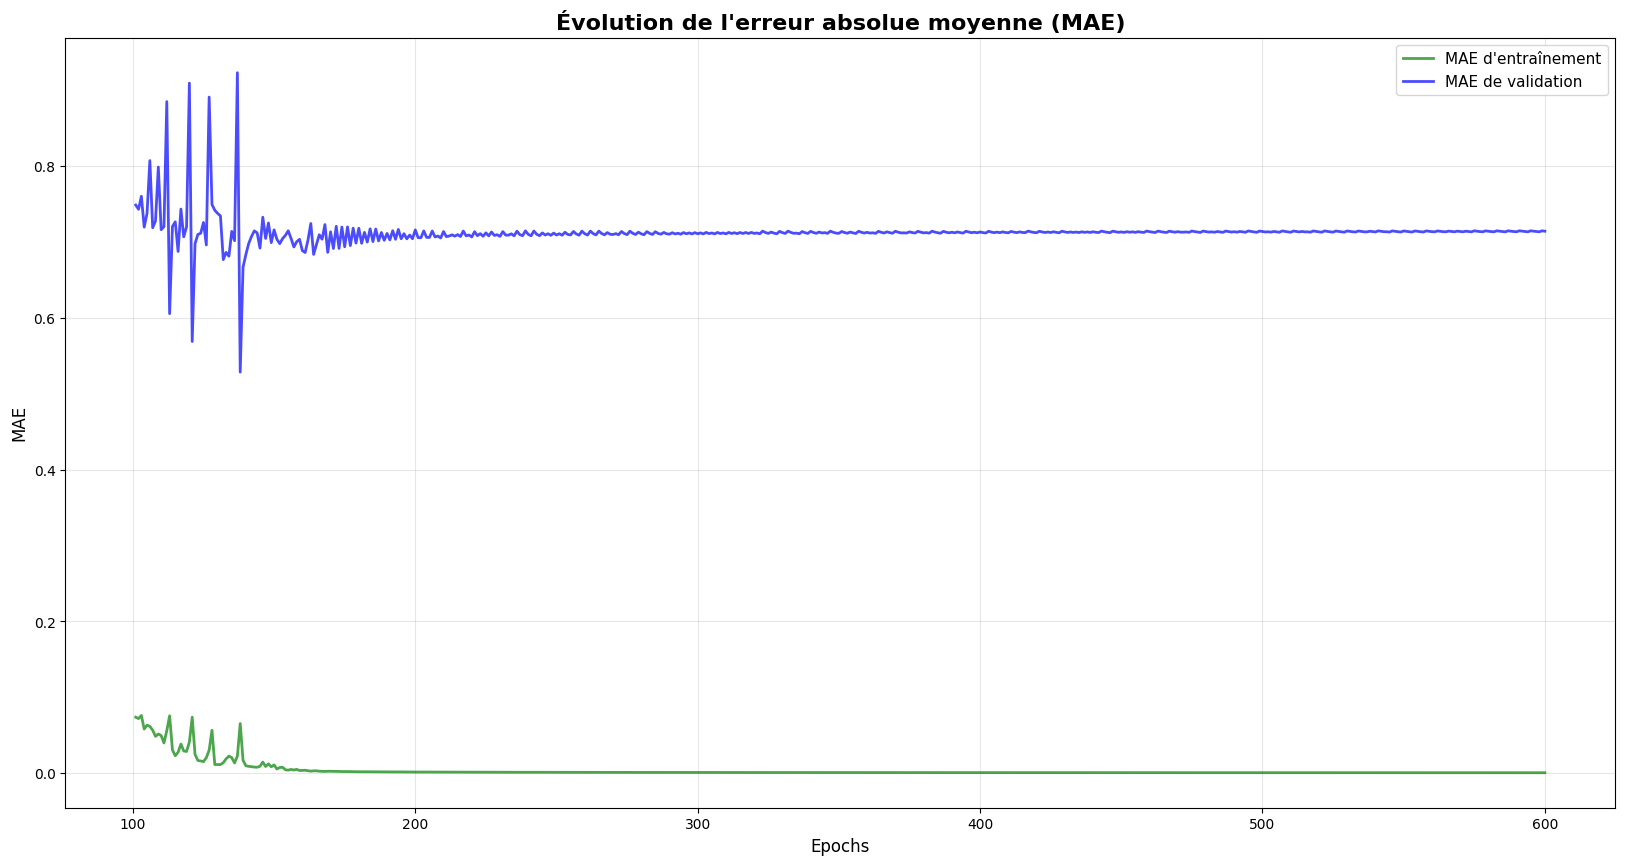

📊 MAE finale :
   - Entraînement : 0.0005
   - Validation   : 0.7145


In [12]:
# Graphique de l'erreur absolue moyenne (MAE)
mae = history.history['mae']           # MAE sur les données d'entraînement
val_mae = history.history['val_mae']  # MAE sur les données de validation

plt.plot(epochs[SKIP:], mae[SKIP:], 'g-', label='MAE d\'entraînement', linewidth=2, alpha=0.7)
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b-', label='MAE de validation', linewidth=2, alpha=0.7)
plt.title('Évolution de l\'erreur absolue moyenne (MAE)', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"📊 MAE finale :")
print(f"   - Entraînement : {mae[-1]:.4f}")
print(f"   - Validation   : {val_mae[-1]:.4f}")


### 🧪 Tester avec les données de test

Maintenant, testons le modèle sur des données qu'il **n'a jamais vues** pendant l'entraînement (ensemble de test).

**Ce qu'on vérifie :**
- Les **prédictions** du modèle (probabilités pour chaque geste)
- Les **vraies valeurs** (labels one-hot)
- La **correspondance** entre les deux

**Interprétation des résultats :**
- `[0.998, 0.002]` → Le modèle prédit 99.8% "punch", 0.2% "flex"
- `[0.001, 0.999]` → Le modèle prédit 0.1% "punch", 99.9% "flex"


In [13]:
# Utiliser le modèle pour prédire sur les données de test
print("🔮 Génération des prédictions sur les données de test...")
predictions = model.predict(inputs_test, verbose=1)

# Afficher les prédictions et les vraies valeurs
print("\n📊 Résultats de prédiction :")
print("=" * 60)
print("Prédictions (probabilités) :")
print(np.round(predictions, decimals=3))
print("\nVraies valeurs (labels) :")
print(outputs_test)

# Calculer la précision
correct = 0
for i in range(len(predictions)):
    pred_gesture = np.argmax(predictions[i])  # Index du geste prédit
    true_gesture = np.argmax(outputs_test[i])  # Index du vrai geste
    if pred_gesture == true_gesture:
        correct += 1

accuracy = correct / len(predictions) * 100
print(f"\n✅ Précision sur les données de test : {accuracy:.1f}% ({correct}/{len(predictions)})")
print(f"   Geste prédit = index avec la probabilité la plus élevée")

🔮 Génération des prédictions sur les données de test...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

📊 Résultats de prédiction :
Prédictions (probabilités) :
[[0.011 0.989]
 [0.018 0.982]]

Vraies valeurs (labels) :
[[0. 1.]
 [0. 1.]]

✅ Précision sur les données de test : 100.0% (2/2)
   Geste prédit = index avec la probabilité la plus élevée


## 📦 Convertir le modèle en TensorFlow Lite

### Pourquoi TensorFlow Lite ?

**TensorFlow Lite (TFLite)** est une version optimisée de TensorFlow pour les appareils embarqués :

- **Taille réduite** : Modèle compressé pour tenir dans la mémoire limitée d'Arduino
- **Performance** : Optimisé pour les microcontrôleurs
- **Compatibilité** : Format standard pour TinyML

### Conversion

Le modèle TensorFlow standard est converti en format `.tflite` qui peut être utilisé sur Arduino avec la bibliothèque TensorFlow Lite for Microcontrollers.

**Taille importante :** Plus le modèle est petit, plus il sera rapide sur Arduino. Notre objectif est généralement < 100 KB.

In [14]:
# ============================================
# CONVERSION EN TENSORFLOW LITE
# ============================================
# Convertir le modèle Keras en format TensorFlow Lite
# Note: Conversion sans quantification (utilise des float32)
# La quantification (int8) réduirait encore plus la taille mais nécessite plus de configuration
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Sauvegarder le modèle sur le disque
with open("gesture_model.tflite", "wb") as f:
    f.write(tflite_model)

# Afficher la taille du modèle
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print(f"✅ Modèle converti avec succès !")
print(f"📦 Taille du modèle : {basic_model_size:,} bytes ({basic_model_size/1024:.2f} KB)")

# Vérifier si la taille est acceptable pour Arduino
if basic_model_size < 100 * 1024:  # < 100 KB
    print("   ✓ Taille acceptable pour Arduino Nano 33 BLE Sense")
else:
    print("   ⚠️ Modèle assez volumineux, considérez la quantification pour réduire la taille")



INFO:tensorflow:Assets written to: C:\Users\walid\AppData\Local\Temp\tmprwac8hj2\assets


INFO:tensorflow:Assets written to: C:\Users\walid\AppData\Local\Temp\tmprwac8hj2\assets


Saved artifact at 'C:\Users\walid\AppData\Local\Temp\tmprwac8hj2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 714), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(1, 2), dtype=tf.float32, name=None)
Captures:
  2298306097424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298307099136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298307424176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298307427520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298307426640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2298307710112: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Modèle converti avec succès !
📦 Taille du modèle : 148,248 bytes (144.77 KB)
   ⚠️ Modèle assez volumineux, considérez la quantification pour réduire la taille


## 🔧 Encoder le modèle dans un fichier header Arduino

### Pourquoi un fichier header ?

Arduino ne peut pas lire directement un fichier `.tflite`. Il faut **intégrer le modèle directement dans le code** comme un tableau de bytes.

### Processus

1. Lire le fichier `.tflite` (binaire)
2. Convertir chaque byte en format hexadécimal (`0x00`, `0xFF`, etc.)
3. Créer un tableau C++ `const unsigned char model[]`
4. Sauvegarder dans `model.h`

### Utilisation sur Arduino

Le fichier `model.h` généré doit être :
- Ajouté comme un onglet dans votre sketch Arduino
- Inclus avec `#include "model.h"`
- Utilisé par la bibliothèque TensorFlow Lite for Microcontrollers

In [15]:
# ============================================
# CONVERSION EN FICHIER HEADER C++
# ============================================
def convert_tflite_to_header(tflite_file, header_file):
    """
    Convertit un fichier TFLite en fichier header C++ compatible Arduino.
    
    Le modèle binaire est converti en un tableau de bytes hexadécimaux
    qui peut être inclus directement dans le code Arduino.
    """
    # Lire le fichier TFLite (mode binaire)
    with open(tflite_file, 'rb') as f:
        tflite_data = f.read()
    
    # Créer le fichier header C++
    with open(header_file, 'w', encoding='utf-8') as f:
        # En-tête du fichier
        f.write("// Modèle TensorFlow Lite pour Arduino\n")
        f.write("// Généré automatiquement - Ne pas modifier manuellement\n\n")
        
        # Déclaration du tableau de bytes
        # __attribute__((aligned(4))) : Alignement sur 4 bytes pour optimiser l'accès mémoire
        f.write("const unsigned char model[] __attribute__((aligned(4))) = {\n")
        
        # Convertir les bytes en format hexadécimal
        # Format: 12 bytes par ligne pour une meilleure lisibilité
        for i in range(0, len(tflite_data), 12):
            chunk = tflite_data[i:i+12]
            # Convertir chaque byte en hexadécimal (0x00 à 0xFF)
            hex_values = ', '.join(f"0x{b:02x}" for b in chunk)
            # Ajouter une virgule sauf pour le dernier chunk
            comma = "," if i + 12 < len(tflite_data) else ""
            f.write(f"  {hex_values}{comma}\n")
        
        f.write("};\n\n")
        
        # Ajouter la longueur du modèle (utile pour certaines bibliothèques)
        f.write(f"const unsigned int model_len = {len(tflite_data)};\n")

# Convertir le modèle
print("🔄 Conversion du modèle en fichier header C++...")
convert_tflite_to_header("gesture_model.tflite", "model.h")

# Afficher la taille du fichier généré
import os
model_h_size = os.path.getsize("model.h")
print(f"✅ Fichier header créé avec succès !")
print(f"📄 Taille du fichier model.h : {model_h_size:,} bytes ({model_h_size/1024:.2f} KB)")
print(f"\n📋 Prochaines étapes :")
print(f"   1. Ouvrez le fichier model.h dans votre éditeur")
print(f"   2. Ajoutez-le comme onglet dans votre sketch Arduino")
print(f"   3. Utilisez-le avec TensorFlow Lite for Microcontrollers")

🔄 Conversion du modèle en fichier header C++...
✅ Fichier header créé avec succès !
📄 Taille du fichier model.h : 926,760 bytes (905.04 KB)

📋 Prochaines étapes :
   1. Ouvrez le fichier model.h dans votre éditeur
   2. Ajoutez-le comme onglet dans votre sketch Arduino
   3. Utilisez-le avec TensorFlow Lite for Microcontrollers


## 🎯 Classification des données IMU sur Arduino

### Prochaines étapes

Maintenant que vous avez un modèle entraîné et converti, il est temps de l'utiliser sur votre Arduino !

### Ce qu'il vous faut

1. **Arduino Nano 33 BLE Sense** avec accéléromètre et gyroscope
2. **Bibliothèque TensorFlow Lite for Microcontrollers** installée dans l'IDE Arduino
3. **Le fichier `model.h`** généré à l'étape précédente
4. **Un sketch Arduino** qui :
   - Lit les données de l'IMU (accéléromètre + gyroscope)
   - Normalise les données (comme pendant l'entraînement)
   - Passe les données au modèle TensorFlow Lite
   - Affiche la prédiction (quel geste a été détecté)

### Résumé de ce que vous avez appris

✅ **Préparation des données** : Normalisation et formatage pour l'entraînement  
✅ **Architecture de réseau de neurones** : Couches, activations (ReLU, softmax)  
✅ **Fonction de perte (Loss)** : MSE pour mesurer l'erreur  
✅ **Optimiseur** : RMSprop pour ajuster les poids  
✅ **Entraînement** : Processus d'apprentissage avec epochs et batch size  
✅ **Évaluation** : Validation et test sur données non vues  
✅ **Conversion** : TensorFlow → TensorFlow Lite → Header C++  

**Félicitations ! Vous avez créé votre premier modèle TinyML ! 🎉**
